# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

grad_check at (0,)  num = 6.000000003503203 anal = 6.0
Gradient check passed!
grad_check at (0,)  num = 1.0000000028043132 anal = 1.0
grad_check at (1,)  num = 1.0000000005838672 anal = 1.0
Gradient check passed!
grad_check at (0, 0)  num = 1.0000000028043132 anal = 1.0
grad_check at (0, 1)  num = 1.0000000005838672 anal = 1.0
grad_check at (1, 0)  num = 0.9999999983634211 anal = 1.0
grad_check at (1, 1)  num = 0.9999999983634211 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

soft max = [2.06106005e-09 4.53978686e-05 9.99954600e-01]
[2.06106005e-09 4.53978686e-05 9.99954600e-01]
soft max = [1. 0. 0.]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, 2)


soft max = [4.50940412e-05 6.69254912e-03 9.93262357e-01]


AttributeError: 'int' object has no attribute 'flatten'

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [156]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
enter of the function =  [[ 1.  2. -1.  1.]] [[2]]
soft max = [[0.20603191 0.56005279 0.02788339 0.20603191]]
log =  3.5797242232074917
NNN SAMPLES!!! =  1
loss , grand (prediction) =  3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]] 
                                                                                                    
enter of the function =  [[ 1.00002  2.      -1.       1.     ]] [[2]]
soft max = [[0.20603518 0.56005049 0.02788327 0.20603106]]
log =  3.5797283438783922
NNN SAMPLES!!! =  1
loss , grand (prediction) =  3.5797283438783922 [[ 0.20603518  0.56005049 -0.97211673  0.20603106]] 
                                                                                                    
enter of the function =  [[ 0.99998  2.      -1.       1.     ]] [[2]]
soft max = [[0.20602864 0.5600551  0.0278835  0.20603276]]
log =  3.5797201026020242
NNN SAMPLES!!! =  1
loss , grand (prediction) =  3.579720

False

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [167]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

enter of linear_softmax [[-1. -1.  1.]  [[ 1.  2.]  [1 1]
                         [ 0.  1.  1.]]  [-1.  1.]       
                                         [ 1.  2.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
loss , grand (prediction), grad by W =  4.370364905207625 [[0.11245721 0.01521943]  [[-0.11245721 -0.01521943]  
                                                           [0.0413707  0.83095266]]  [-0.07108652  0.81573323]  
                                                                                     [ 0.15382791  0.84617209]] 
[[-0.11245721 -0.01521943] 
 [-0.07108652  0.81573323] 
 [ 0.15382791  0.84617209]]
enter of linear_softmax [[-1. -1.  1.]  [[ 1.  2.]  [1 1]
                         [ 0.  1.  1.]]  [-1.  1.]       
                                         [ 1.  2.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
loss , grand (prediction), grad

False

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [8]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

enter of L2  [[ 1.  2.]  0.01
              [-1.  1.]      
              [ 1.  2.]]     
L2 loss, grad =  0.12 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  [[ 1.  2.]  0.01
              [-1.  1.]      
              [ 1.  2.]]     
L2 loss, grad =  0.12 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  [[ 1.0000002  2.       ]  0.01
              [-1.         1.       ]      
              [ 1.         2.       ]]     
L2 loss, grad =  0.12000000400000041 [[ 0.01  0.02] 
                                      [-0.01  0.01] 
                                      [ 0.01  0.02]]
enter of L2  [[ 0.9999998  2.       ]  0.01
              [-1.         1.       ]      
              [ 1.         2.       ]]     
L2 loss, grad =  0.1199999960000004 [[ 0.01  0.02] 
                                     [-0.01  0.01] 
                                     [ 0.01  0.02]]
grad_check at

False

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [147]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

enter of the function =  [[ 0.00465178 -0.0065898   0.01138863 ...  0.00539442  0.02523579 [5 2 2 ... 1 2 4]
                           -0.0100008 ]                                                                     
                          [-0.00176964  0.00404971  0.00156948 ... -0.00666434 -0.00115764                  
                            0.00126712]                                                                     
                          [-0.00240734  0.00169291  0.01001695 ... -0.00460786 -0.00425175                  
                            0.00338654]                                                                     
                          ...                                                                               
                          [ 0.00169839 -0.00535952  0.02034442 ...  0.00763008  0.01760759                  
                           -0.00889147]                                                                     
                   

soft max = [[6.89471594e-128 3.24446722e-138 4.26253939e-149 ... 8.63645266e-140
             8.71115816e-133 1.61631222e-134]                                   
            [4.42777069e-131 5.16356238e-164 1.36553155e-140 ... 6.76138756e-133
             1.09040147e-129 3.06188608e-134]                                   
            [2.40194269e-131 3.95500022e-141 2.63900073e-142 ... 1.40464963e-146
             1.03376923e-122 4.39455599e-126]                                   
            ...                                                                 
            [2.68628912e-142 3.60232046e-162 6.21489037e-145 ... 1.32246233e-115
             4.20015798e-150 5.38398225e-143]                                   
            [6.26955717e-136 1.00105968e-145 4.10314958e-136 ... 3.83959049e-130
             9.52410428e-136 9.03155825e-138]                                   
            [1.53710681e-139 1.58347948e-152 3.14316102e-143 ... 2.37565464e-124
             5.45704200e-148

Epoch 4, loss: inf
enter of the function =  [[-127.30013118 -311.91408094  -76.22914074 ...  212.87600174 [0 2 5 ... 6 4 2]
                           -242.79663494 -179.29024915]                                                 
                          [ -19.62587674  -69.00228905  -89.356754   ...  -51.44384053                  
                             -7.55539693  -35.36141146]                                                 
                          [ -15.99911157  -37.3964249   -46.7857141  ...  -76.37230043                  
                            -13.62952456  -13.99424619]                                                 
                          ...                                                                           
                          [ -74.19853874  -96.60787673  -34.30116628 ...   -5.02162078                  
                           -117.69400058  -79.86490761]                                                 
                          [  15.9669

Epoch 8, loss: inf
enter of the function =  [[  75.12422054   91.99483269 -141.94011188 ... -425.95093671 [1 7 5 ... 0 5 1]
                            276.37235804  165.3765982 ]                                                 
                          [  39.05173559  -15.46208947 -244.58431126 ... -224.56346362                  
                            107.70954726   41.1122469 ]                                                 
                          [-110.42845617 -289.09229006 -111.81918736 ...  111.90119516                  
                           -185.565825   -141.55318464]                                                 
                          ...                                                                           
                          [ -89.41506661 -205.84144885 -182.77571268 ...  -27.49924338                  
                           -101.63232073 -101.57556045]                                                 
                          [-158.3871

'THERE WERE 10 EPOCHS   !!!!!\n'

[102666.1607642957, 1418103.0433875346, 2907044.2615598976, inf, inf, inf, inf, inf, inf, inf]


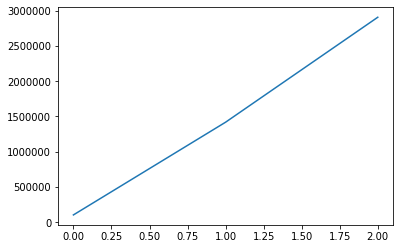

In [148]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [ ]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

In [7]:
np.__version__

'1.16.4'